In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image as Image

seed_choice = 123
tf.keras.utils.set_random_seed(
    seed_choice
)


!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


from  IPython import display

import pathlib
import shutil
import tempfile


2.12.0
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-txtfqqov
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-txtfqqov
  Resolved https://github.com/tensorflow/docs to commit 007d8f49d0b6b58f86158cf063aba99978cfec18
  Preparing metadata (setup.py) ... done


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [4]:
#archive = 'gdrive/MyDrive/Datasets/plants'
archive = 'gdrive/MyDrive/Datasets/tulips'

data_dir = pathlib.Path(archive).with_suffix('')

In [5]:
batch_size = 32

img_dim = 180
img_height = img_dim
img_width = img_dim

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.32,
  subset="training",
  seed=seed_choice,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 303 files belonging to 2 classes.
Using 207 files for training.


In [7]:
STEPS_PER_EPOCH = len(train_ds)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(15, 180, 180, 3)
(15,)


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.32,
  subset="validation",
  seed=seed_choice,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 303 files belonging to 2 classes.
Using 96 files for validation.


In [10]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [11]:
validate_ds =  val_ds

In [12]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [13]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]



def compile_and_fit(model, name, optimizer=None, max_epochs=10):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=1)
  return history

In [14]:
INPUT_SHAPE = (None, img_dim, img_dim, 3)

In [15]:

#    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


small_model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])



small_model.build(INPUT_SHAPE)

In [16]:
size_histories = {}

In [17]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

(0.0, 1.0)

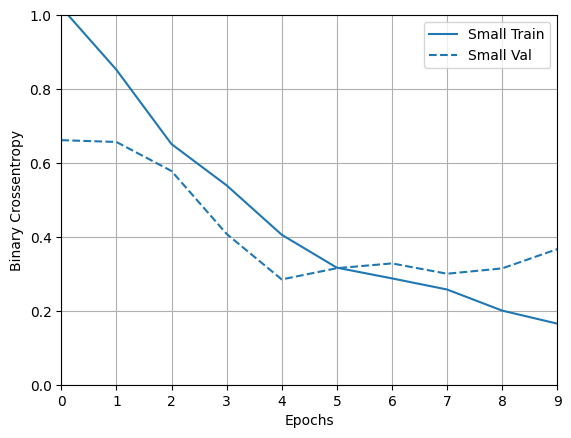

In [18]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 1])


In [19]:
i=1

for image_batch_temp, labels_batch_temp in val_ds:

    if i == 1:
        test_labels = labels_batch_temp.numpy()
        test_images = image_batch_temp.numpy()
    else:
        test_labels = np.concatenate( (test_labels,labels_batch_temp.numpy()), axis=0 )
        test_images = np.concatenate( (test_images,image_batch_temp.numpy()), axis=0 )

    i = i + 1

print(test_labels)

#display(test_images.shape)

[0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0
 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0]


In [20]:
test_images = test_images / 255.0


In [21]:
M = 2

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  #plt.imshow(img, cmap=plt.cm.binary)
  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(M))
  plt.yticks([])
  thisplot = plt.bar(range(M), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [22]:
probability_model = tf.keras.Sequential([small_model,
                                         tf.keras.layers.Softmax()])

In [23]:
predictions = probability_model.predict(val_ds)


3/3 [==============================] - 1s 9ms/step


In [24]:
logits= small_model.predict(val_ds)

3/3 [==============================] - 1s 12ms/step


In [25]:
predictions = tf.sigmoid(logits)

In [26]:
predictions.shape

TensorShape([96, 1])

In [27]:
length = len(predictions)

temp_pred = np.zeros((length,2))


In [28]:
for i in range(length):
  temp_pred[i,0] = 1-predictions[i]
  temp_pred[i,1] = predictions[i]

In [29]:
predictions = temp_pred

In [30]:
class_names = train_ds.class_names


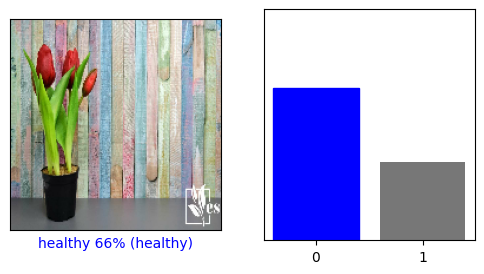

In [31]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

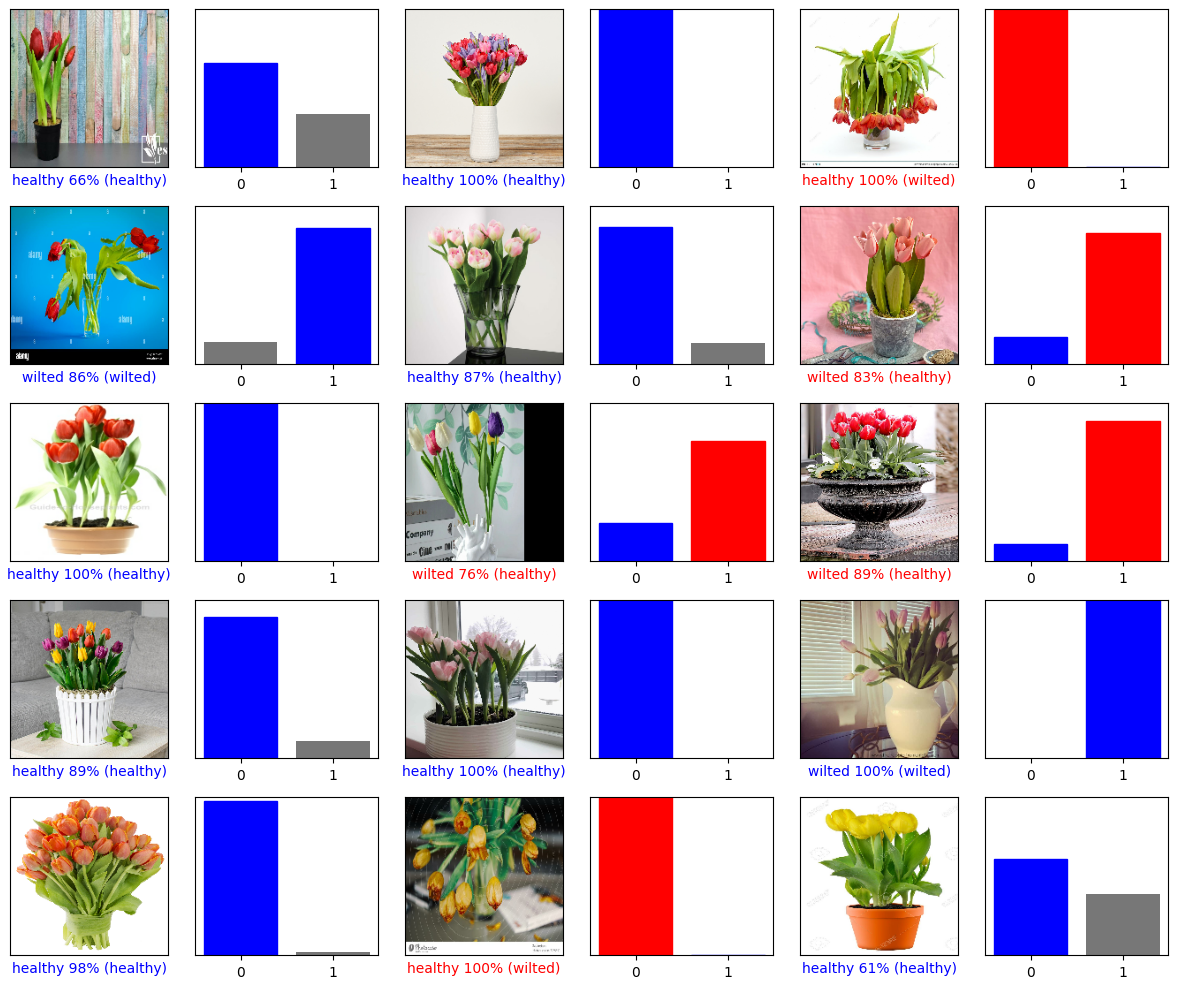

In [32]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [33]:

small_dropout_model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])



small_dropout_model.build(INPUT_SHAPE)

size_histories['Dropout'] = compile_and_fit(small_dropout_model, 'sizes/SmallDropout')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 32)       

(0.0, 1.0)

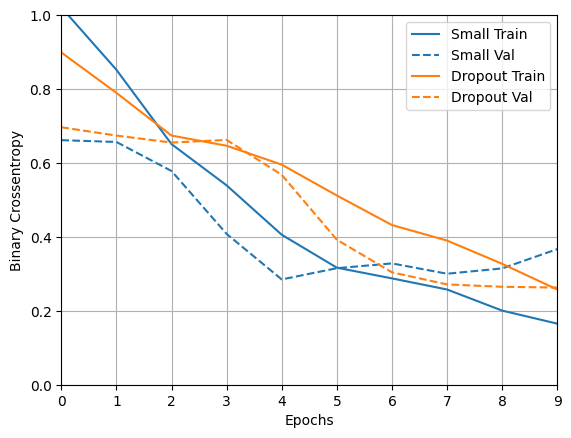

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 1])


In [35]:

small_L2_model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.Dense(1)
])



small_L2_model.build(INPUT_SHAPE)

size_histories['L2 Reg'] = compile_and_fit(small_L2_model, 'sizes/SmallL2')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 32)       

(0.0, 1.0)

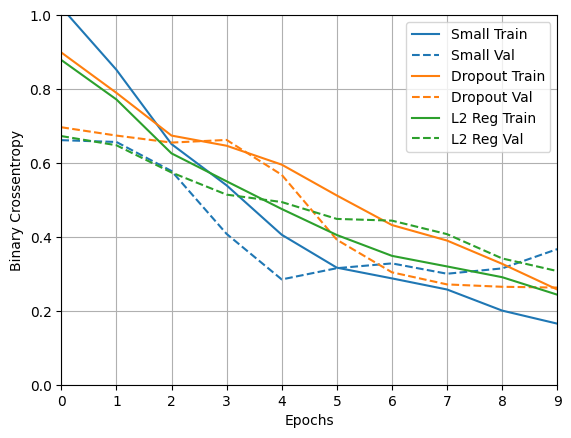

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 1])


In [37]:

small_dropout_L2_model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])



small_dropout_L2_model.build(INPUT_SHAPE)

size_histories['Dropout and L2 Reg'] = compile_and_fit(small_dropout_L2_model, 'sizes/SmallDropoutL2')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 32)       

(0.0, 1.0)

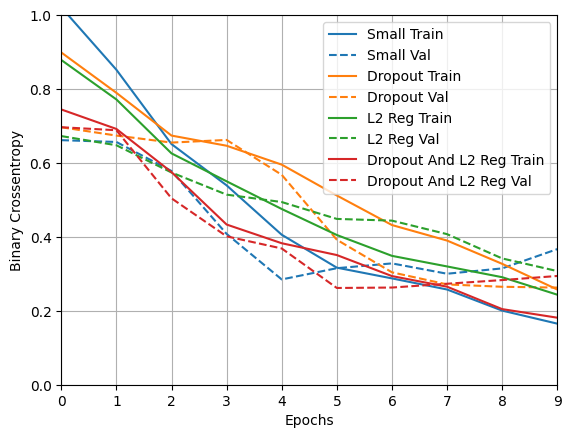

In [38]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 1])
